# Imports

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import penaltyblog as pb
from penaltyblog.scrapers import FootballData
from penaltyblog.matchflow import Flow, where_equals
from penaltyblog.ratings import PiRatingSystem
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, classification_report
import warnings
from statsbombpy.api_client import NoAuthWarning
warnings.filterwarnings("ignore", category=NoAuthWarning)

# Data Preparation

In [2]:
LEAGUE = "ENG Premier League"
SEASON_FD = "2015-2016"
COMPETITION_ID_SB = 2
SEASON_ID_SB = 27

# Fetch Odds Data
df_odds = FootballData(LEAGUE, SEASON_FD).get_fixtures()
odds_cols = ["date", "team_home", "team_away", "goals_home", "goals_away", "psh", "psd", "psa"]
df_odds = df_odds[odds_cols].dropna(subset=['psh', 'psd', 'psa']).copy()

# Fetch StatsBomb Match List
sb_matches_raw = Flow.statsbomb.matches(competition_id=COMPETITION_ID_SB, season_id=SEASON_ID_SB).collect()
df_sb_matches = pd.DataFrame(sb_matches_raw)
df_sb_matches['team_home'] = df_sb_matches['home_team'].apply(lambda x: x['home_team_name'])
df_sb_matches['team_away'] = df_sb_matches['away_team'].apply(lambda x: x['away_team_name'])
df_sb_matches.rename(columns={'match_date': 'date'}, inplace=True)
df_sb_matches = df_sb_matches[['match_id', 'date', 'team_home', 'team_away']]

# Standardize and Merge
df_odds['date'] = pd.to_datetime(df_odds['date'])
df_sb_matches['date'] = pd.to_datetime(df_sb_matches['date'])
name_mapping = {
    'Man United': 'Manchester United', 'Man City': 'Manchester City',
    'West Brom': 'West Bromwich Albion', 'West Ham': 'West Ham United',
    'Stoke': 'Stoke City', 'Swansea': 'Swansea City',
    'Leicester': 'Leicester City', 'Norwich': 'Norwich City',
    'Bournemouth': 'AFC Bournemouth', 'Tottenham': 'Tottenham Hotspur'
}
df_odds.replace({'team_home': name_mapping, 'team_away': name_mapping}, inplace=True)
df_master = pd.merge(df_odds, df_sb_matches, on=['date', 'team_home', 'team_away'], how='inner').sort_values(by='date').reset_index(drop=True)

print(f"Step 1 Complete: Master match list with {len(df_master)} games created.")

Step 1 Complete: Master match list with 342 games created.


# Pre-Calculate Tactical Stats for All Matches

In [3]:
all_match_features = []
for _, row in tqdm(df_master.iterrows(), total=df_master.shape[0], desc="Calculating All-Match Tactical Stats"):
    flow = Flow.statsbomb.events(row['match_id']).cache()
    shot_stats = flow.filter(where_equals("type.name", "Shot")).group_by("team.name").summary({"shots": ("count", "id"), "xg": ("sum", "shot.statsbomb_xg")}).collect()
    match_stats = {'match_id': row['match_id']}
    for team_stats in shot_stats:
        team_name = team_stats['team.name']
        match_stats[team_name] = {'shots': team_stats['shots'], 'xg': team_stats['xg']}
    all_match_features.append(match_stats)

print(f"Step 2 Complete: All tactical stats calculated.")

Calculating All-Match Tactical Stats:   0%|          | 0/342 [00:00<?, ?it/s]

Step 2 Complete: All tactical stats calculated.


# Engineer Pre-Match Features (The Core Pipeline)

In [4]:
final_features_list = []
pi_ratings = PiRatingSystem()

# Convert odds to probabilities
def remove_overround(row):
    return pd.Series(pb.implied.power([row["psh"], row["psd"], row["psa"]])["implied_probabilities"])
df_master[['market_prob_h', 'market_prob_d', 'market_prob_a']] = df_master.apply(remove_overround, axis=1)

# Create historical data for rolling averages
team_history = []
for idx, row in df_master.iterrows():
    home_stats = next((item.get(row['team_home'], {}) for item in all_match_features if item['match_id'] == row['match_id']), {})
    away_stats = next((item.get(row['team_away'], {}) for item in all_match_features if item['match_id'] == row['match_id']), {})
    team_history.append({'date': row['date'], 'team': row['team_home'], 'xg_for': home_stats.get('xg', 0), 'shots_for': home_stats.get('shots', 0), 'xg_against': away_stats.get('xg', 0), 'shots_against': away_stats.get('shots', 0)})
    team_history.append({'date': row['date'], 'team': row['team_away'], 'xg_for': away_stats.get('xg', 0), 'shots_for': away_stats.get('shots', 0), 'xg_against': home_stats.get('xg', 0), 'shots_against': home_stats.get('shots', 0)})
df_history = pd.DataFrame(team_history).set_index('date')
df_form = df_history.groupby('team')[['xg_for', 'xg_against', 'shots_for', 'shots_against']].rolling(window=10, min_periods=1).mean().reset_index()

for idx, row in tqdm(df_master.iterrows(), total=df_master.shape[0], desc="Engineering Pre-Match Features"):
    # Get Pi Rating predictions (form)
    pi_probs = pi_ratings.calculate_match_probabilities(row['team_home'], row['team_away'])
    
    # Get rolling average stats (form)
    home_form = df_form[(df_form['team'] == row['team_home']) & (df_form['date'] < row['date'])].tail(1)
    away_form = df_form[(df_form['team'] == row['team_away']) & (df_form['date'] < row['date'])].tail(1)
    if home_form.empty or away_form.empty: continue # Skip first few matches with no history

    # Assemble feature row
    features = {
        'home_avg_xg_for': home_form['xg_for'].iloc[0], 'away_avg_xg_for': away_form['xg_for'].iloc[0],
        'home_avg_xg_against': home_form['xg_against'].iloc[0], 'away_avg_xg_against': away_form['xg_against'].iloc[0],
        'pi_prob_h': pi_probs['home_win'], 'pi_prob_d': pi_probs['draw'], 'pi_prob_a': pi_probs['away_win'],
        'market_prob_h': row['market_prob_h'], 'market_prob_d': row['market_prob_d'], 'market_prob_a': row['market_prob_a'],
        'result': 1 if row['goals_home'] > row['goals_away'] else (2 if row['goals_home'] < row['goals_away'] else 0)
    }
    final_features_list.append(features)
    
    # Update Pi Ratings for the next match
    pi_ratings.update_ratings(row['team_home'], row['team_away'], row['goals_home'] - row['goals_away'])

df_final = pd.DataFrame(final_features_list)
print(f"Step 3 Complete: Final feature dataset with {len(df_final)} matches created.")

Engineering Pre-Match Features:   0%|          | 0/342 [00:00<?, ?it/s]

Step 3 Complete: Final feature dataset with 332 matches created.


# Final Model Training & Evaluation

In [5]:
features = [col for col in df_final.columns if col != 'result']
X = df_final[features]
y = df_final['result']

# Split data chronologically
split_point = int(len(df_final) * 0.7)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Train and Evaluate
model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, seed=42)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred_class = model.predict(X_test)
loss = log_loss(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred_class)

print(f"\n--- Final Prototype Model Performance ---")
print(f"(Trained on first {len(X_train)} matches, tested on last {len(X_test)} matches)")
print(f"Log Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class, target_names=['Draw', 'Home Win', 'Away Win']))


--- Final Prototype Model Performance ---
(Trained on first 232 matches, tested on last 100 matches)
Log Loss: 1.5546
Accuracy: 43.00%

Classification Report:
              precision    recall  f1-score   support

        Draw       0.33      0.28      0.30        29
    Home Win       0.52      0.60      0.56        43
    Away Win       0.35      0.32      0.33        28

    accuracy                           0.43       100
   macro avg       0.40      0.40      0.40       100
weighted avg       0.42      0.43      0.42       100



# Analysis: Feature Importance

/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_480/972168787.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


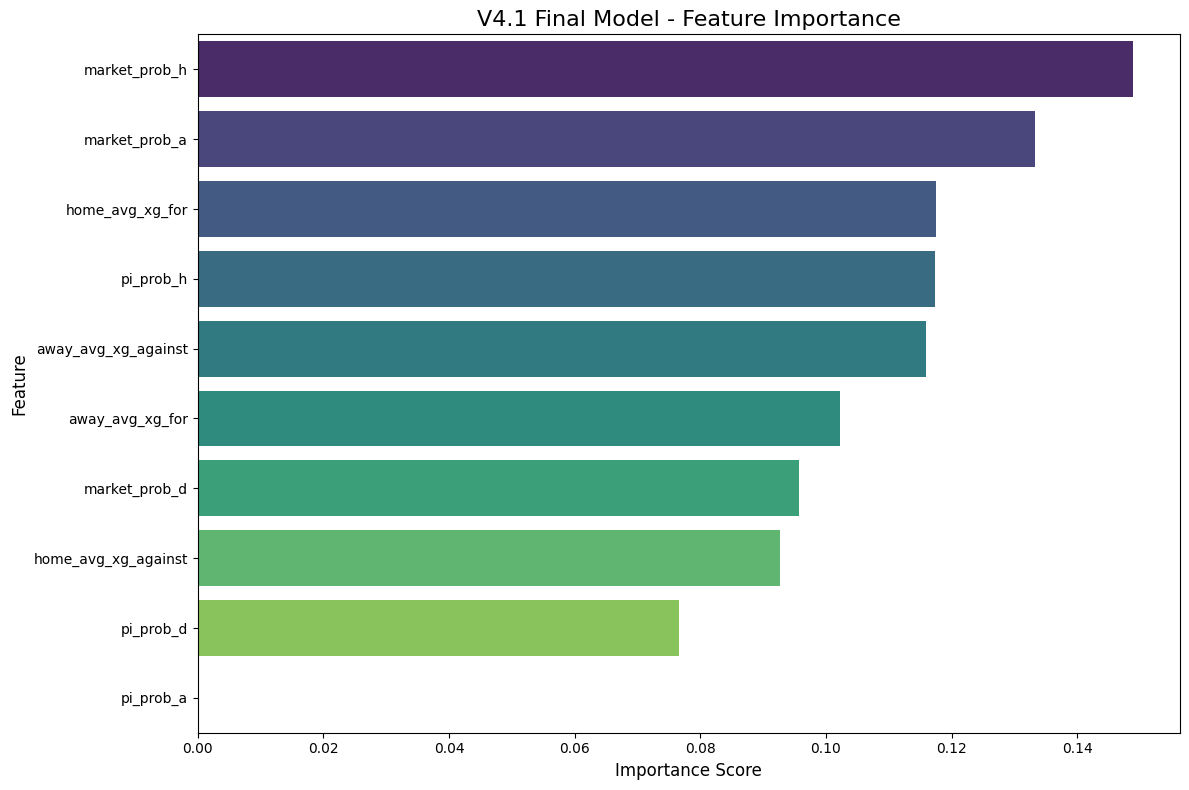

               feature  importance
7        market_prob_h    0.148913
9        market_prob_a    0.133246
0      home_avg_xg_for    0.117465
4            pi_prob_h    0.117308
3  away_avg_xg_against    0.115948
1      away_avg_xg_for    0.102221
8        market_prob_d    0.095726
2  home_avg_xg_against    0.092644
5            pi_prob_d    0.076528
6            pi_prob_a    0.000000


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
df_feature_importance = pd.DataFrame({
    'feature': model.feature_names_in_,  
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance',
    y='feature',
    data=df_feature_importance,
    palette='viridis'
)
plt.title('V4.1 Final Model - Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()
print(df_feature_importance)

# Hyperparameter Tuning with Grid Search

In [18]:
from sklearn.model_selection import GridSearchCV

print("Starting hyperparameter tuning for the final prototype model...")

# Define the grid of parameters to test
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.05]
}

# Set up the Grid Search to optimize for Log Loss
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='multi:softprob', num_class=3, seed=42),
    param_grid=param_grid,
    scoring='neg_log_loss', # We optimize on Log Loss
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Run the Grid Search on the training data
grid_search.fit(X_train, y_train)

print("\nHyperparameter tuning complete.")
print(f"Best parameters found: {grid_search.best_params_}")

# --- Evaluate the new, tuned model ---
tuned_model = grid_search.best_estimator_
y_pred_proba_tuned = tuned_model.predict_proba(X_test)
y_pred_class_tuned = tuned_model.predict(X_test)

loss_tuned = log_loss(y_test, y_pred_proba_tuned)
accuracy_tuned = accuracy_score(y_test, y_pred_class_tuned)

print("\n--- Tuned Prototype Model Performance ---")
print(f"Log Loss: {loss_tuned:.4f}")
print(f"Accuracy: {accuracy_tuned:.2%}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_class_tuned, target_names=['Draw', 'Home Win', 'Away Win']))

Starting hyperparameter tuning for the final prototype model...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Hyperparameter tuning complete.
Best parameters found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}

--- Tuned Prototype Model Performance ---
Log Loss: 1.0093
Accuracy: 47.00%

Classification Report:
              precision    recall  f1-score   support

        Draw       0.30      0.10      0.15        29
    Home Win       0.59      0.70      0.64        43
    Away Win       0.36      0.50      0.42        28

    accuracy                           0.47       100
   macro avg       0.42      0.43      0.40       100
weighted avg       0.44      0.47      0.44       100



# Backtest

In [27]:
# --- 1. Prepare Data ---
features = [col for col in df_final.columns if col != 'result']
X = df_final[features]
y = df_final['result']

# Split data into a larger training set for tuning and a final test set for the backtest
train_split_point = int(len(df_final) * 0.7)
train_df = df_final.iloc[:train_split_point]
test_df = df_final.iloc[train_split_point:]

X_train, y_train = train_df[features], train_df['result']

# --- 2. Find Best Hyperparameters on the Training Set ---
print("--- Step 1: Finding Best Hyperparameters via Grid Search ---")
param_grid = {
    'max_depth': [3, 4],
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.05]
}
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='multi:softprob', num_class=3, seed=42),
    param_grid=param_grid, scoring='neg_log_loss', cv=3, n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"\nBest parameters found: {best_params}")


# --- 3. Run the Walk-Forward Backtest ---
print("\n--- Step 2: Running True Walk-Forward Backtest ---")
predictions_proba = []
predictions_class = []
actuals = []

for i in tqdm(range(len(test_df)), desc="Backtesting Progress"):
    # The training data is ALL data before the current match
    current_match_index = train_split_point + i
    current_train_df = df_final.iloc[:current_match_index]
    
    # The current match to predict is a single row
    current_test_df = df_final.iloc[[current_match_index]]

    # Define features and target for this fold
    X_train_fold, y_train_fold = current_train_df[features], current_train_df['result']
    X_test_fold, y_test_fold = current_test_df[features], current_test_df['result']
    
    # Train a new model on all available past data using the best params
    model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, seed=42, **best_params)
    model.fit(X_train_fold, y_train_fold)
    
    # Predict the single upcoming match
    pred_proba = model.predict_proba(X_test_fold)
    pred_class = model.predict(X_test_fold)
    
    # Store results
    predictions_proba.append(pred_proba[0])
    predictions_class.append(pred_class[0])
    actuals.append(y_test_fold.iloc[0])

# --- 4. Final Evaluation ---
print("\n--- Final Backtest Performance ---")
loss = log_loss(actuals, predictions_proba)
accuracy = accuracy_score(actuals, predictions_class)

print(f"(Backtested on last {len(test_df)} matches with weekly retraining)")
print(f"Log Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(actuals, predictions_class, target_names=['Draw', 'Home Win', 'Away Win']))

--- Step 1: Finding Best Hyperparameters via Grid Search ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}

--- Step 2: Running True Walk-Forward Backtest ---


Backtesting Progress:   0%|          | 0/100 [00:00<?, ?it/s]


--- Final Backtest Performance ---
(Backtested on last 100 matches with weekly retraining)
Log Loss: 1.0329
Accuracy: 51.00%

Classification Report:
              precision    recall  f1-score   support

        Draw       0.44      0.24      0.31        29
    Home Win       0.58      0.72      0.65        43
    Away Win       0.42      0.46      0.44        28

    accuracy                           0.51       100
   macro avg       0.48      0.48      0.47       100
weighted avg       0.50      0.51      0.49       100



/home/harry/Desktop/ML-Predict/EPL-ML/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Training the champion model...
Model ready.

Preparing test set for betting simulation...
Simulating betting performance...

--- Final Betting Backtest Results ---
Total Bets Placed: 145
Successful Bets: 57 (39.31%)
Total Staked: 28189636.80
Final Bankroll: 12837936.32
Profit / Loss: 12837836.32
Return on Investment (ROI): 45.54%

Generating final backtest performance chart...


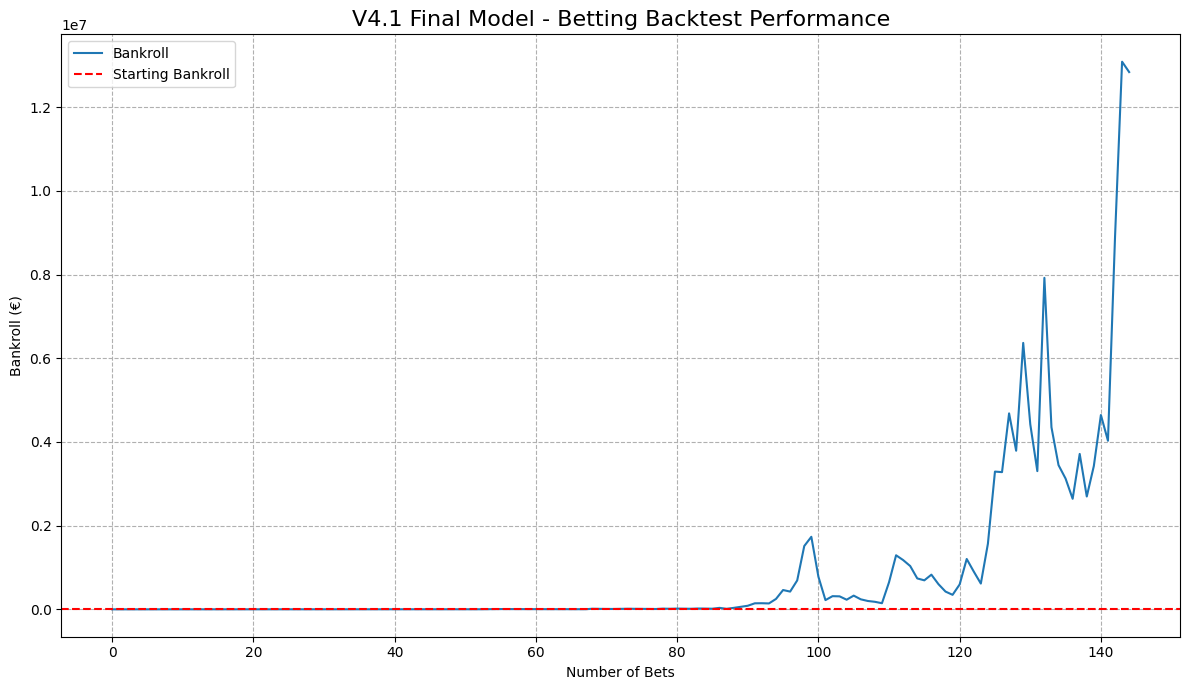

In [29]:
import penaltyblog as pb

# 1. Train the Champion Model
print("Training the champion model...")
model_for_betting = xgb.XGBClassifier(objective='multi:softprob', num_class=3, seed=42, **best_params)
model_for_betting.fit(X_train, y_train)
print("Model ready.")

# 2. Prepare the Test Set with Predictions and All Necessary Data
print("\nPreparing test set for betting simulation...")
test_set_predictions = model_for_betting.predict_proba(X_test)
df_predictions = pd.DataFrame(test_set_predictions, columns=['prob_d_pred', 'prob_h_pred', 'prob_a_pred'], index=X_test.index)

# Join predictions to the test_df
df_test_with_preds = test_df.join(df_predictions)
df_test_with_preds['ftr'] = df_test_with_preds['result'].map({1: 'H', 0: 'D', 2: 'A'})

df_test_with_preds = df_test_with_preds.join(df_master[['date', 'psh', 'psd', 'psa']])


# 3. Run the Betting Simulation
print("Simulating betting performance...")
account = pb.backtest.Account(100)
# Manual trackers for our summary stats
total_bets = 0
successful_bets = 0
total_staked = 0

for _, row in df_test_with_preds.iterrows():
    bets_placed_in_match = 0
    # Kelly Criterion for Home Win
    kc_h = pb.kelly.criterion(row['psh'], row['prob_h_pred'])
    if kc_h > 0:
        stake = account.current_bankroll * kc_h
        bet_won = 1 if row['ftr'] == 'H' else 0
        account.place_bet(row['psh'], stake, bet_won)
        total_staked += stake
        if bet_won: successful_bets += 1
        bets_placed_in_match += 1

    # Kelly Criterion for Draw
    kc_d = pb.kelly.criterion(row['psd'], row['prob_d_pred'])
    if kc_d > 0:
        stake = account.current_bankroll * kc_d
        bet_won = 1 if row['ftr'] == 'D' else 0
        account.place_bet(row['psd'], stake, bet_won)
        total_staked += stake
        if bet_won: successful_bets += 1
        bets_placed_in_match += 1

    # Kelly Criterion for Away Win
    kc_a = pb.kelly.criterion(row['psa'], row['prob_a_pred'])
    if kc_a > 0:
        stake = account.current_bankroll * kc_a
        bet_won = 1 if row['ftr'] == 'A' else 0
        account.place_bet(row['psa'], stake, bet_won)
        total_staked += stake
        if bet_won: successful_bets += 1
        bets_placed_in_match += 1
        
    total_bets += bets_placed_in_match

# 4. Display the Final Betting Results
print("\n--- Final Betting Backtest Results ---")
profit = account.current_bankroll - 100
roi = (profit / total_staked) * 100 if total_staked > 0 else 0
success_rate = (successful_bets / total_bets) * 100 if total_bets > 0 else 0

print(f"Total Bets Placed: {total_bets}")
print(f"Successful Bets: {successful_bets} ({success_rate:.2f}%)")
print(f"Total Staked: {total_staked:.2f}")
print(f"Final Bankroll: {account.current_bankroll:.2f}")
print(f"Profit / Loss: {profit:.2f}")
print(f"Return on Investment (ROI): {roi:.2f}%")

# Plot the performance chart
print("\nGenerating final backtest performance chart...")
plt.figure(figsize=(12, 7))
plt.plot(account.tracker, label="Bankroll")
plt.axhline(y=100, color='r', linestyle='--', label="Starting Bankroll")
plt.title("V4.1 Final Model - Betting Backtest Performance", fontsize=16)
plt.xlabel("Number of Bets")
plt.ylabel("Bankroll (€)")
plt.legend()
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()